# Data Selection for General Medicine 

Iain Bertram 

17 April 2024 -  

Translated to use SnowFlake only 

Generalised for any hospital 

This data selection is based on the table PRD_DAP_EMR_DB.DBO.CV3CLIENT and test results and observations taken from:

### Results 

- PRD_DAP_EMR_DB.DBO.CV3BASICOBSERVATION 
- PRD_DAP_EMR_DB.DBO.CV3ORDER

### Observations 

- PRD_DAP_EMR_DB.DBO.CV3CLIENTDOCUMENT
- PRD_DAP_EMR_DB.DBO.CV3CLIENTVISIT 
- PRD_DAP_EMR_DB.DBO.CV3OBSERVATIONENTRYITEM 
- PRD_DAP_EMR_DB.DBO.CV3OBSERVATIONDOCUMENT
- PRD_DAP_EMR_DB.DBO.CV3OBSERVATION 
- PRD_DAP_EMR_DB.DBO.SCMOBSFSLISTVALUES

### Diagnoses 

- PRD_DAP_EMR_DB.DBO.SXARCMAbstractVisitDetail
- PRD_DAP_EMR_DB.DBO.SXARCMAbstractDiagnosisDetail

### ED Visit Reason 

- PRD_DAP_EMR_DB.DBO.CV3CLIENTDOCUMENT
- PRD_DAP_EMR_DB.DBO.CV3OBSERVATIONDOCUMENT
- PRD_DAP_EMR_DB.DBO.SCMOBSFSLISTVALUES
- PRD_DAP_EMR_DB.DBO.CV3OBSCATALOGMASTERITEM

### Rough Dates 


2023 Calender Year 


In [3]:
# Import Python Libraries 

import sys
import os
import pickle
import time 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from pandasql import sqldf
import sqlalchemy
import snowflake.connector

import pyodbc

from tqdm import tqdm

import Utilities_Country as Utilities
import importlib
importlib.reload(Utilities)

import re
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)



# show all dataframe columns 

pd.set_option('display.max_columns', None)

c:\Users\ibertr02\venvs\ceihml\Lib\site-packages\snowflake\connector\options.py:103: UserWarning: You have an incompatible version of 'pyarrow' installed (15.0.2), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(
Failed to import ArrowResult. No Apache Arrow result set format can be used. ImportError: DLL load failed while importing arrow_iterator: The specified procedure could not be found.


## Date Ranges for data 

Removed Facility selection and looking at Journeys that include hospital transfers. 

Added validation range: ('2023-04-01', '2023-10-01')

In [4]:

# Facility = 'LMH'


# dates = {
#     'RAH':('2023-10-01', '2024-01-01'),
#     'QEH':('2023-10-01', '2024-01-01'),
#     'LMH':('2023-10-01', '2024-01-01'),
#     'MPH':('2023-10-01', '2024-01-01'),
#     'FMC':('2023-10-01', '2024-01-01'),
#     'NHS':('2023-10-01', '2024-01-01'),
# }

start_date =  '2023-09-28'  #dates[Facility][0]
end_date   =  '2024-01-01' #dates[Facility][1]

select_start_date = '2023-10-01'

DataReasons = "Verification"

# Validation 

start_date =  '2023-03-28'  #dates[Facility][0]
end_date   =  '2023-10-01' #dates[Facility][1]

select_start_date = '2023-04-01'

DataReasons = "Verification"

# Main Data Set 

dates = {
    'RAH':('2020-07-01','2024-01-01'),
    'QEH':('2017-01-01', '2024-01-01'),
    'LMH':('2023-01-01', '2024-01-01'),
    'MPH':('2023-01-01', '2024-01-01'),
    'FMC':('2021-08-01', '2024-01-01'),
    'NHS':('2017-01-01', '2024-01-01'),
}

start_date =  '2023-01-01'  #dates[Facility][0]
end_date   =  '2024-01-01' #dates[Facility][1]

select_start_date = '2023-01-01'

DataReasons = "Training"


start_date =  '2023-01-01'  #dates[Facility][0]
end_date   =  '2024-08-01' #dates[Facility][1]

select_start_date = '2023-01-01'

DataReasons = "Verification"
# clinics=Utilities.clinics(Facility)
    
# print(Facility,start_date,end_date,clinics)

## Connection to SnowFlake 

        con = snowflake.connector.connect(
        account='wt61814.australia-east.privatelink',
        user="iain.bertram@sa.gov.au",
        database="DEV_DAP_CAE05_DB",
        warehouse="DEV_DAP_CAE05_M_WH",
        authenticator="externalbrowser",


In [ ]:
# 'snowflake://<user_login_name>:<password>@<account_identifier>/<database_name>/<schema_name>?warehouse=<warehouse_name>&role=<role_name>'

In [5]:
con = Utilities.getConnection()
con.warehouse

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/bda528f7-fca9-432f-bc98-bd7e90d40906/saml2?SAMLRequest=pZNBc%2BIgGIb%2FSoY9JyExWmWMHbfW0Y7dulX3sDcSiFIJZPmI0X%2B%2FJNaZ7qG97I2B54OH74Xx%2FbmU3okbEFqlKAow8rjKNRNqn6Lddu4PkQeWKkalVjxFFw7ofjIGWsqKTGt7UK%2F8T83Bem4jBaRbSFFtFNEUBBBFSw7E5mQzfV6ROMCkMtrqXEv0oeTrCgrAjXWGtxIGwukdrK1IGDZNEzS9QJt9GGOMQzwKHdUi32782d3pEz4KcdLyjnD4%2Bt3tu1DXFnyllV0hIIvtdu2vXzZb5E1vqg9aQV1ys%2BHmJHK%2Be11dBaA1sINoGCUBrcEaKgX1OQUbVEacqOVSqGMASjeFpEee67KqrTsmcKOw4CyUei9cJ5azFFVHwQ5Pi910dXh6e3xZs2WeKVZodZgXq90ZXyqK3%2FCit99kxc%2FdY468X7eo4zbqJUDNl6oN2LopHCd%2BhP043mJM%2BkOS9IM7PPiNvJkLWChqu8rbLTqPoBS50aALq5UT551lxmg%2FHhZ3fpHTkZ%2F04sLP8tHQz9gdH2GW4BEehG3sMbo%2BJdKJmMl%2FN2gcftzu%2FZn%2BcMktZ2stRX7x5tqU1H4ebBRE3YxgftGhhJdUyCljhgO4gKXUzYPhziNF

'DEV_DAP_CAE05_M_WH'

## Get Hospital Visits (Episodes of Care)

Removed ED visit reason as multiple entries can exist per visit (treat like diagnoses)

In [6]:
importlib.reload(Utilities)
visits_df = Utilities.getVisits(start_date,end_date, con)

In [7]:
visits_df.head()

,CLIENTGUID,CHARTGUID,VISITGUID,JOURNEY_ID,AGEONADMISSION,GENDERCODE,IndiginousStatus,LEVELCODE,HOSIPTALPROXY,CHARTRANK,VISITRANK,ACTIVE,VISITSTATUS,INTERNALVISITSTATUS,TYPECODE,CARELEVELCODE,PRIMARYDIAGNOSISCODE,diagnosis_code_desc,PRIMARYPROCEDURECODE,DRG,DRGDescription,MDC,TRIAGE_CATEGORY,EDDIAGNOSISCODE,EDDIAGNOSISCODEDESCRIPTION,CURRENTLOCATION,ADMITDTM,DISCHARGEDTM,LOSNIGHTS,LOSHOUR,DISCHARGEDISPOSITION,DISCHARGELOCATION,CURRENTSERVICE,OLDSERVICE,CURRENTSERVICEDTM,GROUPCODE,SERVICEDESCRIPTION,ADMITSOURCE,ADMITTYPE,EPISODEOFCARE,SOURCEOFREFERRAL,Transfer Service,SAH_DIAGNOSIS,SAH_VISIT_TYPE,SAH_ADMIT_SERVICE,WL Patient Category - Intent,WL Election,CUD_EPISODE_OFCARE,CUD_PATIENT_CATEGORY,CUD_ADMISSION_CATEGORY,CUD_ADMISSION_ELECTION
0,3400200,1595891700170,2184027200270,1000033 - 1,63,Female,Not Aboriginal-TSI,LSC,MGH,1,1,False,DSC,DSC,Emergency,Emergency,None,None,None,None,None,None,3,B349,"Viral infection, unspecified",MGH-ED-Waiting Room,2023-01-02 23:16:00+00:00,2023-01-03 05:14:00+00:00,0,6,ED01 Discharged Home,None,MGH Emergency,,2023-01-02 23:16:57.900000+00:00,MGH-EMER,MGH Emergency,ED Self-Family-Friends,Emergency,None,ED Self-Family-Friends,None,"Viral infection, unspecified :Dx",Emergency,None,None,None,None,None,None,None
1,3400200,1688723000170,2338037600270,1000033 - 3,63,Female,Not Aboriginal-TSI,LSC,MGH,2,1,False,DSC,DSC,Emergency,Emergency,None,None,None,None,None,None,2,S3282,"Fracture of lumbosacral spine, part unspecified",MGH-ED-Bay 06,2023-05-01 12:36:00+00:00,2023-05-02 01:44:00+00:00,1,13,ED02 Admit as Inpatient,None,MGH Emergency,,2023-05-01 12:36:09.437000+00:00,MGH-EMER,MGH Emergency,ED First Aid Provider,Emergency,None,ED First Aid Provider,None,"Fracture of lumbosacral spine, part unspecifie...",Emergency,MGH IP Orthopaedic Surgery / ORTHO,None,None,None,None,None,None
2,3400200,1688723000170,2338708800270,1000033 - 3,63,Female,Not Aboriginal-TSI,LSC,MGH,2,2,False,DSC,DSC,Inpatient,Surgical,S3201,Fracture of lumbar vertebra L1 level,9555003,I68A,"Non-surgical Spinal Disorders, Major Complexity",008,None,None,None,MGH-Surgical-R06-06W,2023-05-01 17:15:00+00:00,2023-05-12 04:52:00+00:00,10,252,IP Home,None,MGH IP Orthopaedic Surgery / O,,2023-05-02 01:52:54.497000+00:00,MGH-ORTSUR,MGH IP Orthopaedic Surgery / ORTHO,IP Casualty-Emergency,Emergency,Acute,IP Casualty-Emergency,None,"Fracture of lumbosacral spine, part unspecifie...",Inpatient,None,Overnight Stay,Private,Acute,Overnight Stay,Ordinary,Public
3,3400200,1710117500170,2374471700270,1000033 - 4,63,Female,Not Aboriginal-TSI,LSC,MGH,4,1,False,DSC,DSC,Inpatient,Surgical,M8098,Unsp osteoporosis w path fx other,9555000,I79B,"Pathological Fractures, Minor Complexity",008,None,None,None,MGH-Surgical-R09-09W,2023-05-26 03:21:00+00:00,2023-06-01 02:00:00+00:00,6,143,IP Home,None,MGH IP Orthopaedic Surgery / O,,2023-05-26 03:28:28.273000+00:00,MGH-ORTSUR,MGH IP Orthopaedic Surgery / ORTHO,IP Other,Not Applicable,Acute,IP Other,None,None,Inpatient,None,Overnight Stay,Public,Acute,Overnight Stay,Ordinary,Public
4,3400200,1898107100170,2695786100270,1000033 - 5,64,Female,Not Aboriginal-TSI,LSC,MGH,5,1,False,DSC,DSC,Emergency,Emergency,None,None,None,None,None,None,3,H813,Other peripheral vertigo,MGH-ED-Waiting Room,2024-01-10 04:26:00+00:00,2024-01-10 10:20:00+00:00,0,6,ED01 Discharged Home,None,MGH Emergency,,2024-01-10 04:26:09.220000+00:00,MGH-EMER,MGH Emergency,ED Self-Family-Friends,Emergency,None,ED Self-Family-Friends,None,Other peripheral vertigo :Dx,Emergency,None,None,None,None,None,None,None


### Save to DataFiles 

In [8]:
Data_Storage_File = 'DataFiles\Visits_Country_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(visits_df, file)

DataFiles\Visits_Country_2023-01-01_2024-08-01_Verification_Stage_01.pkl


In [9]:
Data_Storage_File = 'DataFiles\Visits_Country_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'rb') as file:
    visits_df = pd.read_pickle(file)

DataFiles\Visits_Country_2023-01-01_2024-08-01_Verification_Stage_01.pkl


In [10]:
print(len(visits_df.index))


252304


### Get List of Diagnoses 

This will be two lists, those the Episode of Care started with and hospital acquired. 



In [11]:
# Commentd out so only select data from database when required 
importlib.reload(Utilities)
diagnoses_df,diagnoses_HA_df = Utilities.getDiagnosis( start_date,end_date, con)

In [12]:
# Commentd out so only select data from database when required 
# 'DataFiles\Visits_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
Data_Storage_File = 'DataFiles\Visits_Country_Diagnoses_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump((diagnoses_df,diagnoses_HA_df), file)

DataFiles\Visits_Country_Diagnoses_2023-01-01_2024-08-01_Verification_Stage_01.pkl


In [ ]:
Data_Storage_File = 'DataFiles\Visits_Country_Diagnoses_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'rb') as file:
    (diagnoses_df,diagnoses_HA_df) = pd.read_pickle(file)

### Get List of ED Visit Reasons 

In [13]:
# Commentd out so only select data from database when required 
importlib.reload(Utilities)
visitReasons_df = Utilities.getEDVisitReasons( start_date,end_date, con)

In [14]:
# Commentd out so only select data from database when required 
Data_Storage_File = 'DataFiles\Visits_Country_EDVisitReasons_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(visitReasons_df, file)

DataFiles\Visits_Country_EDVisitReasons_2023-01-01_2024-08-01_Verification_Stage_01.pkl


In [ ]:
Data_Storage_File = 'DataFiles\Visits_Country_EDVisitReasons_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'rb') as file:
    visitReasons_df = pd.read_pickle(file)

### Join Diagnoses to Visits 

In [15]:
temp_df = pd.merge(visits_df,diagnoses_df, left_on="VISITGUID", right_on="VisitGUID" , how='left' )
temp_df.drop('VisitGUID', axis=1, inplace=True)
temp_df.rename(columns={"ALLDIAGNOSIS":"DIAGNOSIS_LIST"},inplace=True)


temp2_df = pd.merge(temp_df,diagnoses_HA_df, 
    left_on="VISITGUID", right_on="VisitGUID" , how='left' )
temp2_df.drop('VisitGUID', axis=1, inplace=True)
temp2_df.rename(columns={"ALLDIAGNOSIS":"HA_DIAGNOSIS_LIST"},inplace=True)

temp2_df = pd.merge(temp2_df,visitReasons_df, 
    left_on="VISITGUID", right_on="VISITGUID" , how='left' )
# temp2_df.drop('VisitGUID', axis=1, inplace=True)
# temp2_df.rename(columns={"ALLDIAGNOSIS":"HA_DIAGNOSIS_LIST"},inplace=True)


# temp2_df.head()


### Add Diagnosis Flags 

In [16]:
importlib.reload(Utilities)
temp3_df = Utilities.addFlags(temp2_df)
# print(temp2_df.iloc[0].DIAGNOSIS_LIST)
# Utilities.sepsis_flag(temp2_df.iloc[0].DIAGNOSIS_LIST)

In [17]:
temp3_df['DIAGNOSIS_LIST'] = temp3_df['DIAGNOSIS_LIST'].fillna('')
temp3_df['HA_DIAGNOSIS_LIST'] = temp3_df['HA_DIAGNOSIS_LIST'].fillna('')

In [18]:
temp3_df = temp3_df.loc[temp3_df.TYPECODE!='zUnscheduled']

In [19]:
temp3_df.head()

,CLIENTGUID,CHARTGUID,VISITGUID,JOURNEY_ID,AGEONADMISSION,GENDERCODE,IndiginousStatus,LEVELCODE,HOSIPTALPROXY,CHARTRANK,VISITRANK,ACTIVE,VISITSTATUS,INTERNALVISITSTATUS,TYPECODE,CARELEVELCODE,PRIMARYDIAGNOSISCODE,diagnosis_code_desc,PRIMARYPROCEDURECODE,DRG,DRGDescription,MDC,TRIAGE_CATEGORY,EDDIAGNOSISCODE,EDDIAGNOSISCODEDESCRIPTION,CURRENTLOCATION,ADMITDTM,DISCHARGEDTM,LOSNIGHTS,LOSHOUR,DISCHARGEDISPOSITION,DISCHARGELOCATION,CURRENTSERVICE,OLDSERVICE,CURRENTSERVICEDTM,GROUPCODE,SERVICEDESCRIPTION,ADMITSOURCE,ADMITTYPE,EPISODEOFCARE,SOURCEOFREFERRAL,Transfer Service,SAH_DIAGNOSIS,SAH_VISIT_TYPE,SAH_ADMIT_SERVICE,WL Patient Category - Intent,WL Election,CUD_EPISODE_OFCARE,CUD_PATIENT_CATEGORY,CUD_ADMISSION_CATEGORY,CUD_ADMISSION_ELECTION,DIAGNOSIS_LIST,HA_DIAGNOSIS_LIST,ED_VISIT_REASON,SepsisFlag,COPDFlag,PneumoniaFlag,PEFlag,HeartFailureFlag,UTIFlag,HASepsisFlag
0,3400200,1595891700170,2184027200270,1000033 - 1,63,Female,Not Aboriginal-TSI,LSC,MGH,1,1,False,DSC,DSC,Emergency,Emergency,None,None,None,None,None,None,3,B349,"Viral infection, unspecified",MGH-ED-Waiting Room,2023-01-02 23:16:00+00:00,2023-01-03 05:14:00+00:00,0,6,ED01 Discharged Home,None,MGH Emergency,,2023-01-02 23:16:57.900000+00:00,MGH-EMER,MGH Emergency,ED Self-Family-Friends,Emergency,None,ED Self-Family-Friends,None,"Viral infection, unspecified :Dx",Emergency,None,None,None,None,None,None,None,,,Systemic.Viral Illness,0,0,0,0,<NA>,0,0
1,3400200,1688723000170,2338037600270,1000033 - 3,63,Female,Not Aboriginal-TSI,LSC,MGH,2,1,False,DSC,DSC,Emergency,Emergency,None,None,None,None,None,None,2,S3282,"Fracture of lumbosacral spine, part unspecified",MGH-ED-Bay 06,2023-05-01 12:36:00+00:00,2023-05-02 01:44:00+00:00,1,13,ED02 Admit as Inpatient,None,MGH Emergency,,2023-05-01 12:36:09.437000+00:00,MGH-EMER,MGH Emergency,ED First Aid Provider,Emergency,None,ED First Aid Provider,None,"Fracture of lumbosacral spine, part unspecifie...",Emergency,MGH IP Orthopaedic Surgery / ORTHO,None,None,None,None,None,None,,,Trauma Other.Chest,0,0,0,0,<NA>,0,0
2,3400200,1688723000170,2338708800270,1000033 - 3,63,Female,Not Aboriginal-TSI,LSC,MGH,2,2,False,DSC,DSC,Inpatient,Surgical,S3201,Fracture of lumbar vertebra L1 level,9555003,I68A,"Non-surgical Spinal Disorders, Major Complexity",008,None,None,None,MGH-Surgical-R06-06W,2023-05-01 17:15:00+00:00,2023-05-12 04:52:00+00:00,10,252,IP Home,None,MGH IP Orthopaedic Surgery / O,,2023-05-02 01:52:54.497000+00:00,MGH-ORTSUR,MGH IP Orthopaedic Surgery / ORTHO,IP Casualty-Emergency,Emergency,Acute,IP Casualty-Emergency,None,"Fracture of lumbosacral spine, part unspecifie...",Inpatient,None,Overnight Stay,Private,Acute,Overnight Stay,Ordinary,Public,S3201 S322 S2232 S923 S400 R060 J981 V4769 Y92...,,NaN,0,0,0,0,0,0,0
3,3400200,1710117500170,2374471700270,1000033 - 4,63,Female,Not Aboriginal-TSI,LSC,MGH,4,1,False,DSC,DSC,Inpatient,Surgical,M8098,Unsp osteoporosis w path fx other,9555000,I79B,"Pathological Fractures, Minor Complexity",008,None,None,None,MGH-Surgical-R09-09W,2023-05-26 03:21:00+00:00,2023-06-01 02:00:00+00:00,6,143,IP Home,None,MGH IP Orthopaedic Surgery / O,,2023-05-26 03:28:28.273000+00:00,MGH-ORTSUR,MGH IP Orthopaedic Surgery / ORTHO,IP Other,Not Applicable,Acute,IP Other,None,None,Inpatient,None,Overnight Stay,Public,Acute,Overnight Stay,Ordinary,Public,M8098 U793 U803,,NaN,0,0,0,0,0,0,0
4,3400200,1898107100170,2695786100270,1000033 - 5,64,Female,Not Aboriginal-TSI,LSC,MGH,5,1,False,DSC,DSC,Emergency,Emergency,None,None,None,None,None,None,3,H813,Other peripheral vertigo,MGH-ED-Waiting Room,2024-01-10 04:26:00+00:00,2024-01-10 10:20:00+00:00,0,6,ED01 Discharged Home,None,MGH Emergency,,2024-01-10 04:26:09.220000+00:00,MGH-EMER,MGH Emergency,ED Self-Family-Friends,Emergency,None,ED Self-Family-Friends,None,Other peripheral vertigo :Dx,Emergency,None,None,None,None,None,None,None,,,Neuro.Vertigo/Dizziness,0,0,0,0,<NA>,0,0


In [20]:
temp3_df.loc[(temp3_df.PRIMARYDIAGNOSISCODE=='I500')&(temp3_df.TYPECODE=='Inpatient')&(temp3_df.EPISODEOFCARE=='Acute')]

,CLIENTGUID,CHARTGUID,VISITGUID,JOURNEY_ID,AGEONADMISSION,GENDERCODE,IndiginousStatus,LEVELCODE,HOSIPTALPROXY,CHARTRANK,VISITRANK,ACTIVE,VISITSTATUS,INTERNALVISITSTATUS,TYPECODE,CARELEVELCODE,PRIMARYDIAGNOSISCODE,diagnosis_code_desc,PRIMARYPROCEDURECODE,DRG,DRGDescription,MDC,TRIAGE_CATEGORY,EDDIAGNOSISCODE,EDDIAGNOSISCODEDESCRIPTION,CURRENTLOCATION,ADMITDTM,DISCHARGEDTM,LOSNIGHTS,LOSHOUR,DISCHARGEDISPOSITION,DISCHARGELOCATION,CURRENTSERVICE,OLDSERVICE,CURRENTSERVICEDTM,GROUPCODE,SERVICEDESCRIPTION,ADMITSOURCE,ADMITTYPE,EPISODEOFCARE,SOURCEOFREFERRAL,Transfer Service,SAH_DIAGNOSIS,SAH_VISIT_TYPE,SAH_ADMIT_SERVICE,WL Patient Category - Intent,WL Election,CUD_EPISODE_OFCARE,CUD_PATIENT_CATEGORY,CUD_ADMISSION_CATEGORY,CUD_ADMISSION_ELECTION,DIAGNOSIS_LIST,HA_DIAGNOSIS_LIST,ED_VISIT_REASON,SepsisFlag,COPDFlag,PneumoniaFlag,PEFlag,HeartFailureFlag,UTIFlag,HASepsisFlag
110,235300200,1810254100170,2545061700270,1002352 - 2,80,Male,Not Aboriginal-TSI,PAG,PAG,2,2,False,DSC,DSC,Inpatient,Medical,I500,Congestive heart failure,9555009,F62B,"Heart Failure and Shock, Minor Complexity",005,None,None,None,PAG-ACAC-A04-A,2023-09-24 00:06:00+00:00,2023-09-26 09:30:00+00:00,2,58,IP Home,None,PAG Medical Physician / MPHYS,,2023-09-24 00:45:50.670000+00:00,PAG-MPHYS,PAG Medical Physician / MPHYS,IP Casualty-Emergency,Emergency,Acute,IP Casualty-Emergency,None,Congestive heart failure :Dx,Inpatient,None,Overnight Stay,Private,Acute,Overnight Stay,Ordinary,Private,I500 R05 J9699 R073 Z951 U823 U821,,NaN,0,0,0,0,1,0,0
148,392300200,1812708000170,2550805900270,1003922 - 1,42,Male,Not Aboriginal-TSI,LSC,MGH,1,2,False,DSC,DSC,Inpatient,Medical,I500,Congestive heart failure,9555002,F62A,"Heart Failure and Shock, Major Complexity",005,None,None,None,MGH-Medical-R07-07,2023-09-26 23:59:00+00:00,2023-10-23 04:39:00+00:00,26,629,IP Home,None,MGH IP General Medical / 002,MGH IP General Medical / 001,2023-09-27 06:36:31.047000+00:00,MGH-GENMED,MGH IP General Medical / 002,IP Casualty-Emergency,Emergency,Acute,IP Casualty-Emergency,None,Syncope and collapse :Dx,Inpatient,None,Overnight Stay,Public,Acute,Overnight Stay,Ordinary,Public,I500 I214 N179 L0313 L88 M6289 N390 B962 A047 ...,,NaN,0,0,0,0,1,1,0
627,1505700200,1666543100170,2301455900270,1015056 - 1,76,Female,Not Aboriginal-TSI,LSC,MGH,1,2,False,DSC,DSC,Inpatient,Medical,I500,Congestive heart failure,9627300,F62A,"Heart Failure and Shock, Major Complexity",005,None,None,None,MGH-Medical-R02-02D,2023-04-02 14:50:00+00:00,2023-04-12 03:45:00+00:00,9,229,IP Home,None,MGH IP General Medical / 002,MGH IP General Medical / 001,2023-04-02 18:43:44.537000+00:00,MGH-GENMED,MGH IP General Medical / 002,IP Casualty-Emergency,Emergency,Acute,IP Casualty-Emergency,None,Chronic obstructive pulmonary disease with acu...,Inpatient,None,Overnight Stay,Public,Acute,Overnight Stay,Ordinary,Public,I500 J440 Z290 L8914 I489 I219 T813 Y836 Y9223...,R11,NaN,0,1,0,0,1,0,0
629,1505700200,1676819300170,2318190600270,1015056 - 2,76,Female,Not Aboriginal-TSI,LSC,MGH,3,2,False,DSC,DSC,Inpatient,Medical,I500,Congestive heart failure,9627300,F62B,"Heart Failure and Shock, Minor Complexity",005,None,None,None,MGH-Private-R09-09D,2023-04-16 09:45:00+00:00,2023-04-22 06:36:00+00:00,6,141,IP Home,None,MGH IP General Medical / 002,MGH IP General Medical / 001,2023-04-16 10:56:40.980000+00:00,MGH-GENMED,MGH IP General Medical / 002,IP Casualty-Emergency,Emergency,Acute,IP Casualty-Emergency,None,Chronic obstructive pulmonary disease with acu...,Inpatient,None,Overnight Stay,Public,Acute,Overnight Stay,Ordinary,Public,I500 J441 Z290 I489 E119 Z9222 Z720 U823 U793 ...,,NaN,0,1,0,0,1,0,0
2303,5276500200,1807583900170,2540656600270,1052731 - 5,74,Male,Not Aboriginal-TSI,LSC,MGH,7,2,False,DSC,DSC,Inpatient,Medical,I500,Congestive heart failure,9555009,F62A,"Heart Failure and Shock, Major Complexity",005,None,None,None,MGH-Medical-R08-08,2023-09-20 10:30:00+00:00,2023-09-29 03:43:00+00:00,9,209,IP Home,None,MGH IP General Medical / 004,MGH IP Gene

In [21]:
temp3_df['SERVICEDESCRIPTION'].unique()

array(['MGH Emergency', 'MGH IP Orthopaedic Surgery / ORTHO',
       'MGH IP General Medical / 001', 'MGH IP General Medical / 004',
       'PAG Emergency', 'VPH IP Dental Surgery / DENTAL', 'SFH Emergency',
       'MRB Emergency', 'MTB Emergency', 'CGL IP MH IRS South / 481',
       'MGH IP General Surgery / SURG', 'MIL IP General Medical / MED',
       'MIL Emergency', 'RHC IP Brain Injury Rehab / 077',
       'SFH IP Gynaecology / GYNAE', 'KIH Emergency',
       'MTB IP General Medical / MED', 'GHS Emergency',
       'GRM IP Mental Health / ACUTE', 'GRM IP Mental Health / HDU',
       'PAH Emergency', 'MGH IP Ophthalmology / OPHTH',
       'MRB Maternity Emergency', 'MRB IP Obstetrics / OBS',
       'SFH IP General Medical / MED', 'BER IP Vascular Surgery / VASC',
       'MGH IP General Medical / 003', 'SFH IP Plastic Surgery / PLAST',
       'MGH IP Urology / URO', 'PAG Medical Physician / MPHYS',
       'NAR Emergency', 'PAG General Surgery / SURG',
       'WHS IP General Surgical

### Select All GenMed Acute Visits 

Require at least stays of > 48 hours 

In [22]:
Emergency_df = temp3_df.loc[temp3_df.TYPECODE=='Emergency'].copy()

In [23]:
Emergency_df.GROUPCODE.unique()

array(['MGH-EMER', 'PAG-EMERG', 'SFH-EMERG', 'MRB-UEMER', 'MTB-BED',
       'MIL-MEMER', 'KIH-KEMER', 'GHS-GEMER', 'PAH-EMERG', 'MRB-UMEMER',
       'NAR-NEMER', 'KAP-PEMER', 'BER-IEMERG', 'BOR-BEMER', 'WHS-WED',
       'KIN-KEMER', 'ROX-REMER', 'TAN-TEMERG', 'MAN-MEMERG', 'ANG-AEMERG',
       'WHS-WMAED', 'MTB-BMATEM', 'NHS-EMERG', 'MEN-EEMER', 'WAI-WEMERG',
       'HAW-HEMER', 'PEN-PEMER', 'SFH-MEMER', 'BAR-BEMER', 'NAR-NMATEM',
       'QUO-QEMER', 'GHS-GMEMER', 'LOX-OEMER', None, 'BER-IMEMER',
       'QEH-EMERG', 'KIH-KMEMER', 'PAH-PMAT', 'LOX-OMEM', 'KAP-PMEMER',
       'MEN-EOED', 'TAI-TEMER'], dtype=object)

### Drop any events with no dagnosis... 

This is not applicable to Emergency admissions. 

In [24]:
Emergency_df = Emergency_df.reset_index(drop=True)


### Build Diagnosis Data Set from GenMed_Acute_df

Needs updating for ED visits. 

In [25]:
Emergency_df.columns

Index(['CLIENTGUID', 'CHARTGUID', 'VISITGUID', 'JOURNEY_ID', 'AGEONADMISSION',
       'GENDERCODE', 'IndiginousStatus', 'LEVELCODE', 'HOSIPTALPROXY',
       'CHARTRANK', 'VISITRANK', 'ACTIVE', 'VISITSTATUS',
       'INTERNALVISITSTATUS', 'TYPECODE', 'CARELEVELCODE',
       'PRIMARYDIAGNOSISCODE', 'diagnosis_code_desc', 'PRIMARYPROCEDURECODE',
       'DRG', 'DRGDescription', 'MDC', 'TRIAGE_CATEGORY', 'EDDIAGNOSISCODE',
       'EDDIAGNOSISCODEDESCRIPTION', 'CURRENTLOCATION', 'ADMITDTM',
       'DISCHARGEDTM', 'LOSNIGHTS', 'LOSHOUR', 'DISCHARGEDISPOSITION',
       'DISCHARGELOCATION', 'CURRENTSERVICE', 'OLDSERVICE',
       'CURRENTSERVICEDTM', 'GROUPCODE', 'SERVICEDESCRIPTION', 'ADMITSOURCE',
       'ADMITTYPE', 'EPISODEOFCARE', 'SOURCEOFREFERRAL', 'Transfer Service',
       'SAH_DIAGNOSIS', 'SAH_VISIT_TYPE', 'SAH_ADMIT_SERVICE',
       'WL Patient Category - Intent', 'WL Election', 'CUD_EPISODE_OFCARE',
       'CUD_PATIENT_CATEGORY', 'CUD_ADMISSION_CATEGORY',
       'CUD_ADMISSION_ELECTI

In [26]:
Emergency_df.PRIMARYDIAGNOSISCODE.unique()

array([None], dtype=object)

In [27]:
columnsToKeep = ['CLIENTGUID', 'CHARTGUID', 'VISITGUID', 'JOURNEY_ID', 'AGEONADMISSION',
       'GENDERCODE', 'IndiginousStatus',  'HOSIPTALPROXY',
       #'PRIMARYDIAGNOSISCODE', 'PRIMARYPROCEDURECODE', 'DRG',  'MDC', #  'TRIAGE_CATEGORY', 'EDDIAGNOSISCODE','ED_VISIT_REASON', 
       'ADMITDTM', 'DISCHARGEDTM', 'LOSNIGHTS', 'LOSHOUR',
       'ADMITSOURCE', 'ADMITTYPE', 'EPISODEOFCARE', 'SOURCEOFREFERRAL',
        'DISCHARGEDISPOSITION',
        'TRIAGE_CATEGORY', 'EDDIAGNOSISCODE',
       'EDDIAGNOSISCODEDESCRIPTION','ED_VISIT_REASON'
]
       # 'DIAGNOSIS_LIST', 'HA_DIAGNOSIS_LIST',
       # 'SepsisFlag', 'COPDFlag', 'PneumoniaFlag', 'PEFlag', 'HeartFailureFlag',
       # 'UTIFlag', 'HASepsisFlag']

### Link Emergency to Inpatient data 

Note: Check that IP is a real IP visit. 
1. Flag Inpatient visits that are at least 24 hours 
2. Flag short visits where they leave the next afternoon, I.e. < 24 hour visits. 
3. Flag where admitted as inpatient within 48 hours in subsequent presentation (not one of the other )

- Connect IP LOS 
- diagnosis flags
- HA Diagnoses
- DRG
- MDC

Select the following discharge dispositions 

['ED02 Admit as Inpatient', 'ED03 Admit to EECU', 
       'ED06 Transfer to Other Hospital']
Not -        'ED09 Died in ED' although check this 

Select first visit per journey code... 



In [28]:
Emergency_IPInfo_df = Emergency_df[columnsToKeep].copy()
# listOfVisitGUIDs = Emergency_IPInfo_df[Emergency_IPInfo_df.DISCHARGEDISPOSITION.isin(['ED02 Admit as Inpatient', 'ED03 Admit to EECU', 'ED06 Transfer to Other Hospital'])].VISITGUID.unique()
listoFJourneys =  Emergency_IPInfo_df.JOURNEY_ID.unique()

In [29]:
dups = temp3_df.loc[temp3_df.JOURNEY_ID.isin(listoFJourneys)].pivot_table(columns=['JOURNEY_ID'], aggfunc='size')
dups.sort_values(ascending=False, inplace=True)
# dups2 = dups[dups.gt(1)]
# dups.head()
journeys_to_Process  = dups.index.to_list()

In [30]:
VariablesToAdd = [ 'DIAGNOSIS_LIST', 'HA_DIAGNOSIS_LIST', 'JOURNEYLOS', 'InitialIPLoS','GROUPCODE', 'CURRENTLOCATION']

In [31]:
temp3_df.TYPECODE.value_counts()

TYPECODE
Emergency          169633
Inpatient           69883
Waiting List-IP     12042
Contracted-IP         743
Name: count, dtype: int64

In [32]:
Emergency_IPInfo_df[VariablesToAdd] = None 

In [33]:
# Emergency_IPInfo_df = Emergency_Reduced_df.copy()
# Bugs when admit date excluded by sleection range inj a journey (edge effects) 

i = 365400

CompleteDropList = []

for i in tqdm(range(0,len(journeys_to_Process))):
    # i=146
    # if i > 20: break
    jID=journeys_to_Process[i]

    tmp_df = temp3_df.loc[(temp3_df.JOURNEY_ID==jID) & (temp3_df.ADMITDTM>start_date)].copy()
    # print(len(tmp_df.index))
    if len(tmp_df.index)>1:

        tmp_df = tmp_df.reset_index(drop=True)
        # tmp_df.head()
        tmp_df['ADMITDTM'] = (tmp_df['ADMITDTM'].dt.tz_localize(None) )
        tmp_df['DISCHARGEDTM'] = (tmp_df['DISCHARGEDTM'].dt.tz_localize(None) )


        EDidx = tmp_df.loc[tmp_df.TYPECODE=='Emergency'].index
        EDChoice = (min(EDidx))
        vGUID = tmp_df.loc[EDChoice].VISITGUID
        dropEDList = tmp_df.loc[(tmp_df.VISITGUID!=vGUID)&(tmp_df.TYPECODE=='Emergency')].VISITGUID.unique()
        IPidx =  tmp_df.loc[tmp_df.TYPECODE!='Emergency'].index
        
        # print(EDChoice,EDidx, IPidx)
        if (len(IPidx>0)):
            
            if len(IPidx[IPidx>EDChoice])>0:
                IPChoice = min(IPidx[IPidx>EDChoice])

                # try: 
                admitDTM =  Emergency_IPInfo_df[Emergency_IPInfo_df.VISITGUID==vGUID].ADMITDTM.values[0]
                dischargeDTM =  Emergency_IPInfo_df[Emergency_IPInfo_df.VISITGUID==vGUID].DISCHARGEDTM.values[0]
                # except:
                #     admitDTM =  Emergency_IPInfo_df[Emergency_IPInfo_df.VISITGUID==vGUID].ADMITDTM
                #     dischargeDTM =  Emergency_IPInfo_df[Emergency_IPInfo_df.VISITGUID==vGUID].DISCHARGEDTM
                    
                    
                

                LastDischargeDTM = tmp_df.iloc[-1].DISCHARGEDTM

                tmp_df['ADMITDTM'] = (tmp_df['ADMITDTM'].dt.tz_localize(None) )
                IPadmitDTM = tmp_df.loc[IPChoice].ADMITDTM
                # dischargeDTM =  Emergency_IPInfo_df[Emergency_IPInfo_df.VISITGUID==vGUID].DISCHARGEDTM.values[0]

                IP48HourWindowIndex = tmp_df.loc[(tmp_df.TYPECODE!='Emergency') & (tmp_df.ADMITDTM < pd.to_datetime(dischargeDTM + pd.Timedelta(days=2)) )].index
                InitialIPLoS = Utilities.timeDiff(dischargeDTM,tmp_df.loc[IP48HourWindowIndex].DISCHARGEDTM.max())
                JourneyLoS = Utilities.timeDiff(IPadmitDTM,LastDischargeDTM)



                # print(' '.join(tmp_df.loc[IP48HourWindowIndex].DIAGNOSIS_LIST.values))
                ED_IP_Diagnosis_List = ' '.join(tmp_df.loc[IP48HourWindowIndex].DIAGNOSIS_LIST.values)
                ED_IP_HADiagnosis_List = ' '.join(tmp_df.loc[IP48HourWindowIndex].HA_DIAGNOSIS_LIST.values)
                ED_IP_GroupCodes =  ' '.join(tmp_df.loc[IP48HourWindowIndex].GROUPCODE.values)
                ED_IP_CurrLOcations =  ' '.join(tmp_df.loc[IP48HourWindowIndex].CURRENTLOCATION.values)



                # print(ED_IP_Diagnosis_List,ED_IP_HADiagnosis_List,JourneyLoS,InitialIPLoS,ED_IP_GroupCodes,ED_IP_CurrLOcations)


                Emergency_IPInfo_df.loc[Emergency_IPInfo_df.VISITGUID==vGUID, VariablesToAdd] = [ED_IP_Diagnosis_List, ED_IP_HADiagnosis_List, JourneyLoS,InitialIPLoS,ED_IP_GroupCodes,ED_IP_CurrLOcations]
                dropEDIdx= Emergency_IPInfo_df.loc[Emergency_IPInfo_df.VISITGUID.isin(dropEDList)].index
                CompleteDropList.append(dropEDIdx)
                # Emergency_IPInfo_df.drop(dropEDIdx,inplace=True)
                Emergency_IPInfo_df.loc[Emergency_IPInfo_df.VISITGUID==vGUID]

100%|██████████| 166635/166635 [55:19<00:00, 50.20it/s] 


In [34]:
tmp_df

,CLIENTGUID,CHARTGUID,VISITGUID,JOURNEY_ID,AGEONADMISSION,GENDERCODE,IndiginousStatus,LEVELCODE,HOSIPTALPROXY,CHARTRANK,VISITRANK,ACTIVE,VISITSTATUS,INTERNALVISITSTATUS,TYPECODE,CARELEVELCODE,PRIMARYDIAGNOSISCODE,diagnosis_code_desc,PRIMARYPROCEDURECODE,DRG,DRGDescription,MDC,TRIAGE_CATEGORY,EDDIAGNOSISCODE,EDDIAGNOSISCODEDESCRIPTION,CURRENTLOCATION,ADMITDTM,DISCHARGEDTM,LOSNIGHTS,LOSHOUR,DISCHARGEDISPOSITION,DISCHARGELOCATION,CURRENTSERVICE,OLDSERVICE,CURRENTSERVICEDTM,GROUPCODE,SERVICEDESCRIPTION,ADMITSOURCE,ADMITTYPE,EPISODEOFCARE,SOURCEOFREFERRAL,Transfer Service,SAH_DIAGNOSIS,SAH_VISIT_TYPE,SAH_ADMIT_SERVICE,WL Patient Category - Intent,WL Election,CUD_EPISODE_OFCARE,CUD_PATIENT_CATEGORY,CUD_ADMISSION_CATEGORY,CUD_ADMISSION_ELECTION,DIAGNOSIS_LIST,HA_DIAGNOSIS_LIST,ED_VISIT_REASON,SepsisFlag,COPDFlag,PneumoniaFlag,PEFlag,HeartFailureFlag,UTIFlag,HASepsisFlag
252299,340542000200,1898429900170,2696314800270,4136845 - 1,79,Male,Not Aboriginal-TSI,BHF,SFH,1,1,False,DSC,DSC,Emergency,Emergency,None,None,None,None,None,None,3,R296,"Tendency to fall, not elsewhere classified",SFH-ED-Exam Room,2024-01-10 11:14:00+00:00,2024-01-11 04:03:00+00:00,1,17,ED01 Discharged Home,None,SFH Emergency,,2024-01-10 11:14:47.610000+00:00,SFH-EMERG,SFH Emergency,ED First Aid Provider,Emergency,None,ED First Aid Provider,None,"Tendency to fall, not elsewhere classified :Dx",Emergency,None,None,None,None,None,None,None,,,Trauma Other.Head,0,0,0,0,<NA>,0,0


In [35]:
# Commentd out so only select data from database when required 
Data_Storage_File = 'DataFiles\Emergency_Country_IPInfo__{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(Emergency_IPInfo_df, file)

DataFiles\Emergency_Country_IPInfo__2023-01-01_2024-08-01_Verification_Stage_01.pkl


In [36]:
DropList = np.concatenate( CompleteDropList)
len(DropList)

1472

In [37]:
Emergency_IPInfo_df.drop(DropList,inplace=True)

In [38]:
Emergency_IPInfo_df = Emergency_IPInfo_df.reset_index(drop=True)


### Add diagnosis information for the IP record. 

In [39]:
Emergency_IPInfo_df['DIAGNOSIS_LIST'] = Emergency_IPInfo_df['DIAGNOSIS_LIST'].fillna('')
Emergency_IPInfo_df['HA_DIAGNOSIS_LIST'] = Emergency_IPInfo_df['HA_DIAGNOSIS_LIST'].fillna('')

In [40]:
importlib.reload(Utilities)
Emergency_IPInfo_df = Utilities.addFlags(Emergency_IPInfo_df)

In [41]:
Emergency_IPInfo_df.head()

,CLIENTGUID,CHARTGUID,VISITGUID,JOURNEY_ID,AGEONADMISSION,GENDERCODE,IndiginousStatus,HOSIPTALPROXY,ADMITDTM,DISCHARGEDTM,LOSNIGHTS,LOSHOUR,ADMITSOURCE,ADMITTYPE,EPISODEOFCARE,SOURCEOFREFERRAL,DISCHARGEDISPOSITION,TRIAGE_CATEGORY,EDDIAGNOSISCODE,EDDIAGNOSISCODEDESCRIPTION,ED_VISIT_REASON,DIAGNOSIS_LIST,HA_DIAGNOSIS_LIST,JOURNEYLOS,InitialIPLoS,GROUPCODE,CURRENTLOCATION,SepsisFlag,COPDFlag,PneumoniaFlag,PEFlag,HeartFailureFlag,UTIFlag,HASepsisFlag
0,3400200,1595891700170,2184027200270,1000033 - 1,63,Female,Not Aboriginal-TSI,MGH,2023-01-02 23:16:00+00:00,2023-01-03 05:14:00+00:00,0,6,ED Self-Family-Friends,Emergency,None,ED Self-Family-Friends,ED01 Discharged Home,3,B349,"Viral infection, unspecified",Systemic.Viral Illness,,,None,None,None,None,0,0,0,0,0,0,0
1,3400200,1688723000170,2338037600270,1000033 - 3,63,Female,Not Aboriginal-TSI,MGH,2023-05-01 12:36:00+00:00,2023-05-02 01:44:00+00:00,1,13,ED First Aid Provider,Emergency,None,ED First Aid Provider,ED02 Admit as Inpatient,2,S3282,"Fracture of lumbosacral spine, part unspecified",Trauma Other.Chest,S3201 S322 S2232 S923 S400 R060 J981 V4769 Y92...,,251.616667,243.133333,MGH-ORTSUR,MGH-Surgical-R06-06W,0,0,0,0,0,0,0
2,3400200,1898107100170,2695786100270,1000033 - 5,64,Female,Not Aboriginal-TSI,MGH,2024-01-10 04:26:00+00:00,2024-01-10 10:20:00+00:00,0,6,ED Self-Family-Friends,Emergency,None,ED Self-Family-Friends,ED01 Discharged Home,3,H813,Other peripheral vertigo,Neuro.Vertigo/Dizziness,,,None,None,None,None,0,0,0,0,0,0,0
3,3400200,1948779200170,2783286300270,1000033 - 6,64,Female,Not Aboriginal-TSI,MGH,2024-03-08 00:07:00+00:00,2024-03-08 07:53:00+00:00,0,8,ED Self-Family-Friends,Emergency,None,ED Self-Family-Friends,ED02 Admit as Inpatient,3,M545,Low back pain,Gastrointestinal.Abdominal Pain,M4806 R522 B373 N771 U803 U793,,72.4,71.633333,MGH-GENMED,MGH-Maternity-R01-01D,0,0,0,0,0,0,0
4,3400200,1955929100170,2795325500270,1000033 - 7,64,Female,Not Aboriginal-TSI,MGH,2024-03-17 15:36:00+00:00,2024-03-18 02:53:00+00:00,0,11,ED First Aid Provider,Emergency,None,ED First Aid Provider,ED02 Admit as Inpatient,3,M545,Low back pain,Musculo-Skeletal.Back Pain,M545 R522,,59.416667,54.3,MGH-GENMED,MGH-Medical-R05-05W,0,0,0,0,0,0,0


In [47]:
Emergency_IPInfo_tmp_df = Emergency_IPInfo_df.merge(temp3_df[['VISITGUID','ED_VISIT_REASON']],on='VISITGUID',how='left')

In [48]:
Emergency_IPInfo_tmp_df.ED_VISIT_REASON.unique()

array(['Systemic.Viral Illness', 'Trauma Other.Chest',
       'Neuro.Vertigo/Dizziness', ...,
       'Systemic.Malaise -- Mental Health.Other',
       'Gastrointestinal.Nausea/Vomiting -- Neuro.Headache',
       'Skin.Suspected Infection -- Procedure/Tests.Review -- Procedure/Tests.Review'],
      dtype=object)

In [49]:
Emergency_IPInfo_df = Emergency_IPInfo_tmp_df

In [50]:
originalProblemList = ['Resp Distress / Shortness Of Breath', 'Respiratory Distress / S.O.B.',
                            'Resp.Distress/Short Of Breath', 'Resp.Distress/Shortness of Breath',
                            'Distress & Short Of Breath (Sob)', 'Resp.Distress/Shortness of Breath -- Resp.Distress/Shortness of Breath',
                            'Renal.Shunt/Fistula/Vascath Problem -- Resp.Distress/Shortness of Breath',
                            'Resp.Distress/Shortness of Breath -- Deformity/Swelling.Other',
                            'Resp.Distress/Shortness of Breath -- Resp.Suspected Infection',
                            'Cardiovascular.Chest Pain -- Resp.Distress/Shortness of Breath',
                            'Resp.Other -- Resp.Distress/Shortness of Breath',
                            'Resp.Distress/Shortness of Breath',
                            ]

### Set Shortness of Breath Flag 

In [51]:
Emergency_IPInfo_df["SOBFlag"] = np.where(Emergency_IPInfo_df.ED_VISIT_REASON.isin( originalProblemList),1,0)

### Get Observations

In [52]:
importlib.reload(Utilities)

Obs_Of_Interest = Utilities.getObs_Of_Interest()
listOfObs =  list(Obs_Of_Interest.keys()) 
listofObsTimes = listOfObs.copy()
for i in range(len(listofObsTimes)):
    listofObsTimes[i] = listofObsTimes[i]+"Dtm"

print(listOfObs) 


['FirstBloodGlucose', 'FirstBPDiastolic', 'FirstBPSystolic', 'FirstGCSScoreAdult', 'FirstLevelofConsciousness', 'FirstO2Flow', 'FirstPulseRateBPM', 'FirstRespiration', 'FirstSpO2', 'FirstTemperatureDegreesC', 'FirstWeightKg', 'FirstUrinalysisBlood', 'FirstUrinalysisLeukocytes', 'FirstPainAssessment']


In [54]:

Emergency_IPInfo_withObs_df = pd.concat([Emergency_IPInfo_df,pd.DataFrame([[None,]*(len(listOfObs)+len(listofObsTimes))],
        index=Emergency_IPInfo_df.index,
        columns=listOfObs+listofObsTimes)], axis=1)



In [55]:
guidList = Emergency_IPInfo_withObs_df.VISITGUID.unique()

In [56]:
importlib.reload(Utilities)

numBatches = int(len(guidList)/50000)
guidBatches = np.array_split(guidList,numBatches)


obs_list = []

for i in range(numBatches):

    query = (Utilities.queryObservations().format(tuple(guidBatches[i])))
    obs_list.append(pd.read_sql(query,con))

In [57]:
obs_list[0].head()

,ObservationGUID,VISITIDCODE,CLIENTVISITGUID,CLIENTGUID,OBSITEMGUID,OBSERVATIONDESC,DATEENTERED,OBSERVATIONVALUE,SORTSEQNUM,UNITOFMEASURE
0,12658334371,112195787,2281944000270,76223100200,702900,SpO2 (%),2023-03-19 02:39:28.923000+00:00,98,NaN,%
1,13162773871,112561059,2333773800270,33951100200,302900,Pulse Rate (beats/min),2023-04-28 00:45:18.623000+00:00,84,NaN,bpm
2,12024208411,111720779,2214206700270,29351400200,502900,Respiration (breaths/min),2023-01-25 21:56:44.933000+00:00,18,NaN,bpm
3,12135755071,111800166,2225702900270,32361300200,5102900,Level of Consciousness Score,2023-02-04 20:34:39.157000+00:00,1,NaN,None
4,18052369971,115858725,2781540700270,34841800200,702900,SpO2 (%),2024-03-07 17:43:03.323000+00:00,93,NaN,%


In [58]:
all_obs_df =  pd.concat(obs_list, ignore_index=True, sort=False)

In [59]:
Data_Storage_File = 'DataFiles\Emergency_Country_Observations_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(all_obs_df, file)

DataFiles\Emergency_Country_Observations_2023-01-01_2024-08-01_Verification_Stage_01.pkl


In [60]:
print(len(all_obs_df.index))

6154210


In [61]:
Data_Storage_File = 'DataFiles\Emergency_Country_Observations_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'rb') as file:
    all_obs_df = pd.read_pickle(file)

DataFiles\Emergency_Country_Observations_2023-01-01_2024-08-01_Verification_Stage_01.pkl


In [62]:

import re
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
length = len(Emergency_IPInfo_withObs_df.index)
numberCheck = re.compile(".*\d.*")
count=0

for i in tqdm(range(0,length)):
    # if i > 5: break
    visitGUID = Emergency_IPInfo_withObs_df.iloc[i].VISITGUID        
    # EDVisitGUID = GenMed_Encounters_withObsAll.iloc[i].ED_VISITGUID
    tmpList = []
    tmpList.append(visitGUID)
    # if not  pd.isna( EDVisitGUID): tmpList.append(EDVisitGUID)
    tmp_obs_df = None 
    
    # if not  pd.isna( EDVisitGUID): 
        # tmp_obs_df = all_obs_df.loc[(all_obs_df.CLIENTVISITGUID==visitGUID) | (all_obs_df.CLIENTVISITGUID==EDVisitGUID)  ].copy()
    # else: 
    tmp_obs_df = all_obs_df.loc[(all_obs_df.CLIENTVISITGUID==visitGUID)  ].copy()
    tmp_obs_df = tmp_obs_df[ (tmp_obs_df.SORTSEQNUM!=2) ].copy()
    

    tmp_obs_df = tmp_obs_df.dropna(axis=0, subset='OBSERVATIONVALUE')
    tmp_obs_df.sort_values(by='DATEENTERED', inplace=True)
    for key in Obs_Of_Interest:
        # print(key)
        lenObs = len(tmp_obs_df.loc[tmp_obs_df.OBSERVATIONDESC==Obs_Of_Interest[key]])
        # print(lenObs)
        if (lenObs > 0):
            tmpValue = tmp_obs_df.loc[tmp_obs_df.OBSERVATIONDESC==Obs_Of_Interest[key]].iloc[0].OBSERVATIONVALUE
            tmpDate= tmp_obs_df.loc[tmp_obs_df.OBSERVATIONDESC==Obs_Of_Interest[key]].iloc[0].DATEENTERED	
            # print(tmpValue, tmpDate)
            Emergency_IPInfo_withObs_df.loc[Emergency_IPInfo_withObs_df.VISITGUID==visitGUID, key] = tmpValue
            Emergency_IPInfo_withObs_df.loc[Emergency_IPInfo_withObs_df.VISITGUID==visitGUID, key+'Dtm'] = tmpDate
    

100%|██████████| 168161/168161 [2:39:40<00:00, 17.55it/s]  


In [63]:
Data_Storage_File = 'DataFiles\Emergency_Country_AllObs_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(Emergency_IPInfo_withObs_df, file)

DataFiles\Emergency_Country_AllObs_2023-01-01_2024-08-01_Verification_Stage_01.pkl


In [ ]:
Data_Storage_File = 'DataFiles\Emergency_Country_AllObs_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'rb') as file:
    GenMed_Encounters_withObsAll = pd.read_pickle(file)

### Remove all entries with no vital signs observations 

Question, what is minimum number of obs? 

Note: 51770 out of 371783 visits do not have Observations 

In [64]:
empty = Emergency_IPInfo_withObs_df.loc[Emergency_IPInfo_withObs_df[listOfObs].isnull().all(1)].index


print(len(empty))
print(len(Emergency_IPInfo_withObs_df.index))


18968
168161


In [66]:
Emergency_IPInfo_withObs_df.drop(empty,inplace=True)
print(len(Emergency_IPInfo_withObs_df.index))

149193


### No Pathology Results for ED at this time

Will add, but not required other than possibly blood gases. 

In [67]:
guidList = Emergency_IPInfo_withObs_df.VISITGUID.unique()
# EDguidList = GenMed_Encounters_withObsAll.loc[~GenMed_Encounters_withObsAll.ED_VISITGUID.isna()].ED_VISITGUID.unique()
# AllGuidList = list(guidList) + list(EDguidList)
numBatches = int(len(guidList)/50000)
guidBatches = np.array_split(guidList,numBatches)
print(numBatches)

2


In [68]:
importlib.reload(Utilities)


res_list = []

for i in range(numBatches):

    query = (Utilities.queryResults().format(tuple(guidBatches[i])))
    res_list.append(pd.read_sql(query,con))


# query = Utilities.queryResults().format(tuple(guidList))
# res_df =  pd.read_sql(query,con)
# query = Utilities.queryResults().format(tuple(EDguidList))
# res2_df =  pd.read_sql(query,con)

In [69]:
all_res_df =  pd.concat(res_list, ignore_index=True, sort=False)


In [70]:
Data_Storage_File = 'DataFiles\Emergency_Country_Results_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(all_res_df, file)

DataFiles\Emergency_Country_Results_2023-01-01_2024-08-01_Verification_Stage_01.pkl


In [ ]:
Data_Storage_File = 'DataFiles\Emergency_Country_Results_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'rb') as file:
    all_res_df = pd.read_pickle(file)

In [71]:
res2_df = all_res_df.dropna(axis=0, subset='VALUE').copy()

### Drop blood tests platelets with clotted or clumped 

In [72]:
idx = res2_df[(res2_df.ITEMNAME=='Platelet Count')&(res2_df['VALUE'].isin(['Clumped','Clotted'])) ].index
res2_df.drop(idx,inplace=True)

In [73]:
idx = res2_df[(res2_df.ITEMNAME=='D-Dimer')&(res2_df['VALUE'].isin(['Clumped','Clotted'])) ].index
res2_df.drop(idx,inplace=True)


In [74]:
# res2_df[res2_df.ITEMNAME=='Inspired O2 Arterial']

In [74]:
importlib.reload(Utilities)
print(Utilities.getResultsofInterest())


Res_Of_Interest = Utilities.getResultsofInterest()
listOfResKeys=list(Res_Of_Interest.keys())
listofResKeys2 = listOfResKeys.copy()
for i in range(len(listofResKeys2)):
    listofResKeys2[i] = listofResKeys2[i]+"Dtm"


{'FirstEstimatedGlomerularFiltrationRate': '.Estimated Glomerular Filtration Rate', 'FirstCreatinine': 'Creatinine - Serum', 'FirstAlbumin': 'Albumin Level', 'FirstTotalBilirubin': 'Bilirubin Level Total', 'FirstAlkalinePhosphatase': 'Alkaline Phosphatase Level', 'FirstAlanineAminotransferase': 'Alanine Aminotransferase Level', 'FirstAspartateAminotransferase': 'Aspartate Aminotransferase', 'FirstGammaGlutamylTransferase': 'Gamma Glutamyl Transferase Level', 'FirstLactateDehydrogenase': 'Lactate Dehydrogenase', 'FirstHaemoglobin': 'Haemoglobin', 'FirstWhiteCellCount': 'White Cell Count', 'FirstPlateletCount': 'Platelet Count', 'FirstNeutrophils': 'Absolute Neutrophil Count', 'FirstDDimer': 'D-Dimer', 'FirstCreactiveprotein': 'C-Reactive Protein', 'FirstTroponinT': 'Troponin T Level', 'FirstNTproBNP': 'NT-pro Brain Natriuretic Peptide', 'First50pOxygenSaturationVenous': '50% Oxygen Saturation Venous', 'FirstAnionGapVenous': 'Anion Gap Venous', 'FirstBaseExcessVenous': 'Base Excess Venou

In [75]:
print(listOfResKeys) 

Emergency_IPInfo_Complete = pd.concat(
        [Emergency_IPInfo_withObs_df, pd.DataFrame([[None,]*(len(listOfResKeys)+len(listofResKeys2))],
        index=Emergency_IPInfo_withObs_df.index,
        columns=listOfResKeys+listofResKeys2)], axis=1)

['FirstEstimatedGlomerularFiltrationRate', 'FirstCreatinine', 'FirstAlbumin', 'FirstTotalBilirubin', 'FirstAlkalinePhosphatase', 'FirstAlanineAminotransferase', 'FirstAspartateAminotransferase', 'FirstGammaGlutamylTransferase', 'FirstLactateDehydrogenase', 'FirstHaemoglobin', 'FirstWhiteCellCount', 'FirstPlateletCount', 'FirstNeutrophils', 'FirstDDimer', 'FirstCreactiveprotein', 'FirstTroponinT', 'FirstNTproBNP', 'First50pOxygenSaturationVenous', 'FirstAnionGapVenous', 'FirstBaseExcessVenous', 'FirstBilirubinVenous', 'FirstCarboxyhaemoglobinVenous', 'FirstChlorideDirectVenous', 'FirstCreatinineVenous', 'FirstGlucoseVenous', 'FirstIonised Calcium Venous', 'FirstLactateVenous', 'FirstMethaemoglobinVenous', 'FirstOxygenSaturationVenous', 'FirstOxyhaemoglobinVenous', 'FirstpCO2Venous', 'FirstpHVenous', 'FirstpO2Venous', 'FirstPotassiumDirectVenous', 'FirstReducedHaemoglobinVenous', 'FirstSodiumDirectVenous', 'FirstTotalHaemoglobinVenous', 'First50pOxygenSaturationArterial', 'FirstAnionGapA

In [76]:

import re
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
length = len(Emergency_IPInfo_Complete.index)
numberCheck = re.compile(".*\d.*")
count=0

print(length)

for i in tqdm(range(0,length)):
    # if i > 5: break
    visitGUID = Emergency_IPInfo_Complete.iloc[i].VISITGUID        
    # EDVisitGUID = GenMed_Encounters_Complete.iloc[i].ED_VISITGUID
    tmpList = []
    tmpList.append(visitGUID)
    # if not  pd.isna( EDVisitGUID): tmpList.append(EDVisitGUID)
    tmp_obs_df = None 
    # 
    # if not  pd.isna( EDVisitGUID): 
    # tmp_obs_df = res2_df.loc[(res2_df.CLIENTVISITGUID==visitGUID) | (res2_df.CLIENTVISITGUID==EDVisitGUID)  ].copy()
    # else: 
    tmp_obs_df = res2_df.loc[(res2_df.CLIENTVISITGUID==visitGUID)  ].copy()
    
    # tmp_obs_df = all_obs_df.loc[all_obs_df.CLIENTVISITGUID.isin(tmpList) ].copy()
    # print(len(tmp_obs_df.index))
    # print(visitGUID,EDVisitGUID)  
    # tmpString = '{}'.format(visitGUID)
    # if not  pd.isna( EDVisitGUID): tmpString = '{},{}'.format(visitGUID,EDVisitGUID) 
    # query = (Utilities.queryObservations().format(tmpString))
    # print(query)
    
    
    # obs_df = pd.read_sql(query,con)
    # obs_df = pd.read_sql_query(sqlalchemy.text(Utilities.queryObservations().format(visitGUID)), conn)
    # tmp_obs_df = tmp_obs_df.dropna(axis=0, subset='OBSERVATIONVALUE')
    tmp_obs_df.sort_values(by='result_entered', inplace=True)
    for key in listOfResKeys:
        # print(key)
        lenObs = len(tmp_obs_df.loc[tmp_obs_df.ITEMNAME==Res_Of_Interest[key]])
        # print(lenObs)
        if (lenObs > 0):
            tmpValue = tmp_obs_df.loc[tmp_obs_df.ITEMNAME==Res_Of_Interest[key]].iloc[0].VALUE
            tmpDate= tmp_obs_df.loc[tmp_obs_df.ITEMNAME==Res_Of_Interest[key]].iloc[0].result_entered	
            # print(tmpValue, tmpDate)
            Emergency_IPInfo_Complete.loc[Emergency_IPInfo_Complete.VISITGUID==visitGUID, key] = tmpValue
            Emergency_IPInfo_Complete.loc[Emergency_IPInfo_Complete.VISITGUID==visitGUID, key+'Dtm'] = tmpDate
    

149193


100%|██████████| 149193/149193 [2:57:02<00:00, 14.05it/s]  


In [77]:
empty = Emergency_IPInfo_Complete.loc[Emergency_IPInfo_Complete[listOfResKeys].isnull().all(1)].index


In [78]:
print(len(empty)," visits with no results at all")

92693  visits with no results at all


### Do Not Drop ED visits with no pathology results

In [79]:
# GenMed_Encounters_Complete.drop(empty,inplace=True)
# print(len(GenMed_Encounters_Complete.index))

In [80]:
Data_Storage_File = 'DataFiles\Emergency_Country_Complete_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(Emergency_IPInfo_Complete, file)

DataFiles\Emergency_Country_Complete_2023-01-01_2024-08-01_Verification_Stage_01.pkl


In [ ]:
Data_Storage_File = 'DataFiles\Emergency_Country_Complete_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)


with open(Data_Storage_File, 'rb') as file:
    Emergency_IPInfo_Complete = pd.read_pickle(file)

In [83]:
# # for key in listOfResKeys:
# #     print("---------  ", key,"-------------------------",GenMed_Encounters_Complete[key].isnull().all())

# for key in listOfResKeys:
#     if GenMed_Encounters_Complete[key].isnull().all(): 
        
#         print(key,GenMed_Encounters_Complete[key].isnull().all())



### Remove Empty Columns (No Information)

In [81]:
# key
for key in listOfResKeys+listOfObs:
    # print(key)  

    tmp = Emergency_IPInfo_Complete[~Emergency_IPInfo_Complete[key].isna()][key]
    tmp2 = tmp[~tmp.str.replace('.','',1).str.replace('-','',1).str.isnumeric()]
    testLength = len(tmp2)
    if testLength>0:
        print(key,testLength)
        print(tmp2.unique())

FirstEstimatedGlomerularFiltrationRate 18667
['>90']
FirstTotalBilirubin 846
['<3']
FirstAlkalinePhosphatase 1
['<5']
FirstAlanineAminotransferase 109
['<5']
FirstAspartateAminotransferase 2
['<5']
FirstGammaGlutamylTransferase 13
['<3']
FirstDDimer 140
['<0.20' '<0.21' '>80.00']
FirstCreactiveprotein 718
['<0.3']
FirstTroponinT 160
['<3']
FirstNTproBNP 220
['<50' '>35000' '>34999']
FirstBilirubinVenous 9427
['<2']
FirstBilirubinArterial 107
['<2']
FirstUrinalysisBlood 30856
['Trace' 'Negative' 'Moderate' 'Large+++' 'large' 'Small+' 'Trace-intact'
 'Small' 'trace' 'Large' 'Moderate++' 'small non haem' 'small ' 'small'
 'Trace -lysed ' 'LARGE' 'LARGE DAY 1 Menstural Cycle ' 'SMALL' 'Large '
 'Trace- intact' 'trace- intact' 'Trace-lysed'
 'LARGE - Patient reports menstrating at time of  u/a ' 'Trace-Lysed'
 'Large, on period' 'Trace-Intact' 'trace-intact' 'large ' 'T-intact'
 'LARGE ' 'bLOOD IS LARGE ' '1g' 'small blood' 'Large On period '
 'trace-lysed' 'Trace - Haemolised' 'large, havi

In [82]:
importlib.reload(Utilities)
print(Utilities.getResultsofInterest())
Emergency_IPInfo_Complete_Numeric = Utilities.replaceNonNUmerical(Emergency_IPInfo_Complete)

{'FirstEstimatedGlomerularFiltrationRate': '.Estimated Glomerular Filtration Rate', 'FirstCreatinine': 'Creatinine - Serum', 'FirstAlbumin': 'Albumin Level', 'FirstTotalBilirubin': 'Bilirubin Level Total', 'FirstAlkalinePhosphatase': 'Alkaline Phosphatase Level', 'FirstAlanineAminotransferase': 'Alanine Aminotransferase Level', 'FirstAspartateAminotransferase': 'Aspartate Aminotransferase', 'FirstGammaGlutamylTransferase': 'Gamma Glutamyl Transferase Level', 'FirstLactateDehydrogenase': 'Lactate Dehydrogenase', 'FirstHaemoglobin': 'Haemoglobin', 'FirstWhiteCellCount': 'White Cell Count', 'FirstPlateletCount': 'Platelet Count', 'FirstNeutrophils': 'Absolute Neutrophil Count', 'FirstDDimer': 'D-Dimer', 'FirstCreactiveprotein': 'C-Reactive Protein', 'FirstTroponinT': 'Troponin T Level', 'FirstNTproBNP': 'NT-pro Brain Natriuretic Peptide', 'First50pOxygenSaturationVenous': '50% Oxygen Saturation Venous', 'FirstAnionGapVenous': 'Anion Gap Venous', 'FirstBaseExcessVenous': 'Base Excess Venou

In [83]:
key='FirstUrinalysisBlood'
Emergency_IPInfo_Complete_Numeric[key].unique()

array([1, None, 0, 3, 4, 2, 'LRG', 'Slight change in colour ', 'NA',
       'GROSS', 'Lrg'], dtype=object)

In [84]:
for key in listOfResKeys+listOfObs:
    Emergency_IPInfo_Complete_Numeric[key] = pd.to_numeric(Emergency_IPInfo_Complete_Numeric[key],errors='coerce')

    # print(key,GenMed_Encounters_Complete_Numeric[key].dtype)  

### Problematic Tests

- FirstInspiredO2Venous and Arterial 
- 


In [85]:
intList = ['FirstEstimatedGlomerularFiltrationRate', 'FirstCreatinine', 'FirstAlbumin', 'FirstTotalBilirubin',
           'FirstAlkalinePhosphatase', 'FirstAspartateAminotransferase', 'FirstLactateDehydrogenase', 
           'FirstHaemoglobin',  'FirstPlateletCount' ,'FirstTroponinT', 'FirstNTproBNP', 
           'FirstAnionGapVenous',  'FirstBilirubinVenous', 'FirstChlorideDirectVenous', 'FirstCreatinineVenous',
           'FirstOxygenSaturationVenous', 'FirstpCO2Venous', 'FirstpO2Venous', 'FirstSodiumDirectVenous',
           'FirstTotalHaemoglobinVenous', 
           'FirstAnionGapArterial', 'FirstBilirubinArterial', 'FirstChlorideDirectArterial', 'FirstCreatinineArterial',
           'FirstOxygenSaturationArterial', 'FirstpCO2Arterial', 'FirstpO2Arterial', 'FirstSodiumDirectArterial',
           'FirstTotalHaemoglobinArterial', 
           'FirstPulseRateBPM', 'FirstRespiration', 'FirstSpO2', 'FirstUrinalysisBlood', 'FirstUrinalysisLeukocytes',
           'FirstPainAssessment', 'FirstBPSystolic', 'FirstBPDiastolic'
           ]

for key in intList:
    Emergency_IPInfo_Complete_Numeric[key] = Emergency_IPInfo_Complete_Numeric[key].astype('Int64')


In [86]:
Data_Storage_File = 'DataFiles\Emergency_Country_IPInfo_Complete_Numeric_Numeric_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(Emergency_IPInfo_Complete_Numeric, file)

DataFiles\Emergency_Country_IPInfo_Complete_Numeric_Numeric_2023-01-01_2024-08-01_Verification_Stage_01.pkl


In [110]:
# Data_Storage_File = 'DataFiles\GenMed_Encounters_Complete_Numeric_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
# print(Data_Storage_File)


# with open(Data_Storage_File, 'rb') as file:
#     GenMed_Encounters_Complete_Numeric = pd.read_pickle(file)

### Plot Results



In [101]:
# GenMed_Encounters_Complete_Numeric['SepsisFlag'] = GenMed_Encounters_Complete_Numeric['SepsisFlag'].astype("category")

In [87]:
plotSettings = {
    #  ( bins, xmin, xmax, log/linear)
    'FirstPainAssessment': (11,-0.5,10.5,'log','Pain Assessment'),
    'FirstBPSystolic': (50,50,250,'log', 'BP Systolic [mm Hg]'),
    'FirstBPDiastolic': (50,0,200,'log', 'BP Diastolic [mm Hg]'),
    'FirstEstimatedGlomerularFiltrationRate': (50,0,100,'log',r"Estimated Glomerular Filtration Rate [mL/min/1.73m$^{2}$]"),
    'FirstCreatinine': (50,0,800,'log',r"Creatinine - Serum  [$\mu$mol/L]"),
    'FirstAlbumin': (60,0,60,'log','Albumin  Level [g/L]'),
    'FirstTotalBilirubin': (60,0,100,'log',r"Total Bilirubin Level  [$\mu$mol/L]"),
    'FirstAlkalinePhosphatase': (60,0,800,'log','Alkaline Phosphatase Level [U/L]'),
    'FirstAlanineAminotransferase': (60,0,700,'log','Alanine Aminotransferase Level [U/L]'),
    'FirstAspartateAminotransferase': (60,0,700,'log','Aspartate Aminotransferase Level [U/L]'),
    'FirstGammaGlutamylTransferase': (60,0,700,'log','Gamma Glutamyl Transferase Level [U/L]'),
    'FirstLactateDehydrogenase': (60,0,1200,'log','Lactate Dehydrogenase [U/L]'),
    'FirstHaemoglobin': (50,10, 220,'log','Haemoglobin [g/L]'),
    'FirstWhiteCellCount': (50,0, 50,'log',r"White Cell Count [$\times 10^{9}$/L]"),
    'FirstPlateletCount': (50,0, 1000,'log',r"Platelet Count [$\times 10^{9}$/L]"),
    'FirstNeutrophils': (50,0, 50,'log',r"Absolute Neutrophil  Count [$\times 10^{9}$/L]"),
    'FirstDDimer': (40,0, 20,'log',r"D-Dimer [mg/L]"),
    'FirstCreactiveprotein': (50,0, 600,'log',r"C-Reactive Protein [mg/L]"),
    'FirstTroponinT': (50,0, 600,'log',r"Troponin T Level [mg/L]"),
    'FirstNTproBNP': (50,0, 40000,'log',r"NT-pro Brain Natriuretic Peptide [mg/L]"),
    
    'FirstAnionGapVenous': (50,0, 50,'log',r"Anion Gap Venous [mmol/L]"),
    'FirstAnionGapArterial': (50,0, 50,'log',r"Anion Gap Arterial [mmol/L]"),
    'FirstBaseExcessVenous': (50,-30, 30,'log',r"Base Excess Venous [mmol/L]"),
    'FirstBaseExcessArterial': (50,-30, 30,'log',r"Base Excess Arterial [mmol/L]"),
    'FirstBilirubinVenous': (60,0, 60,'log',r"Bilirubin Venous [$\mu$mol/L]"),
    'FirstBilirubinArterial': (60,0, 60,'log',r"Bilirubin Arterial [$\mu$mol/L]"),
    'FirstCarboxyhaemoglobinVenous': (50,0, 20,'log',r"Carboxyhaemoglobin Venous [%]"),
    'FirstCarboxyhaemoglobinArterial': (50,0, 20,'log',r"Carboxyhaemoglobin Arterial [%]"),
    'FirstChlorideDirectVenous': (50,50, 150,'log',r"Chloride Direct Venous [mmol/L]"),
    'FirstChlorideDirectArterial': (50,50, 150,'log',r"Chloride Direct Arterial [mmol/L]"),
    'FirstCreatinineVenous':(50,0,500,'log',r"Creatinine Venous [$\mu$mol/L]"),
    'FirstCreatinineArterial':(50,0,500,'log',r"Creatinine Arterial [$\mu$mol/L]"),
    'FirstGlucoseVenous':(50,0,30,'log',r"Glucose  Venous [mmol/L]"),
    'FirstGlucoseArterial':(50,0,30,'log',r"Glucose  Arterial [mmol/L]"),
    'FirstIonised Calcium Venous':(50,0,2,'log',r"Ionised Calcium Venous [mmol/L]"),
    'FirstIonised Calcium Arterial':(50,0,2,'log',r"Ionised Calcium Arterial [mmol/L]"),
    'FirstLactateVenous':(50,0,30,'log',r"Lactate Venous [mmol/L]"),
    'FirstLactateArterial':(50,0,30,'log',r"Lactate Arterial [mmol/L]"),
    'FirstMethaemoglobinVenous': (20,0, 3,'log',r"Methaemoglobin Venous [%]"),
    'FirstMethaemoglobinArterial': (20,0, 3,'log',r"Methaemoglobin Arterial [%]"),
    'FirstOxygenSaturationVenous': (50,0, 100,'log',r"Oxygen Saturation Venous [%]"),
    'FirstOxygenSaturationArterial': (50,0, 100,'log',r"Oxygen Saturation Arterial [%]"),
    'FirstOxyhaemoglobinVenous': (50,0, 100,'log',r"Oxyhaemoglobin Venous [%]"),
    'FirstOxyhaemoglobinArterial': (50,0, 100,'log',r"Oxyhaemoglobin Arterial [%]"),
    'FirstReducedHaemoglobinVenous': (50,0, 100,'log',r"Reduced Haemoglobin Venous [%]"),
    'FirstReducedHaemoglobinArterial': (50,0, 100,'log',r"Reduced Haemoglobin Arterial [%]"),
    'FirstTotalHaemoglobinVenous': (50,10, 220,'log','Total Haemoglobin Venous [g/L]'),
    'FirstTotalHaemoglobinArterial': (50,10, 220,'log','Total Haemoglobin Arterial [g/L]'), 
    'FirstpCO2Venous': (50,0,150,'log', 'pCO2 Venous [mm Hg]'),
    'FirstpCO2Arterial': (50,0,150,'log', 'pCO2 Arterial [mm Hg]'),
    'FirstpO2Venous': (50,0,200,'log', 'pO2 Venous [mm Hg]'),
    'FirstpO2Arterial': (50,0,200,'log', 'pO2 Arterial [mm Hg]'),
    'FirstpHVenous': (50,6.8,7.8,'log', 'pH Venous'),
    'FirstpHArterial': (50,6.8,7.8,'log', 'pH Arterial'),
    'FirstPotassiumDirectVenous':(50,0,10,'log',r"Potassium Direct Venous [mmol/L]"),
    'FirstPotassiumDirectArterial':(50,0,10,'log',r"Potassium Direct Arterial [mmol/L]"),
    'FirstSodiumDirectVenous':(50,100,180,'log',r"Sodium Direct Venous [mmol/L]"),
    'FirstSodiumDirectArterial':(50,100,180,'log',r"Sodium Direct Arterial [mmol/L]"),}

plotSettings = Utilities.plotSettings()

In [88]:
key='FirstBloodGlucose'
print(key)
# (listOfResKeys+listOfObs)[key]
{**Obs_Of_Interest, **Res_Of_Interest}[key]

FirstBloodGlucose


'Blood Glucose'

<Figure size 640x480 with 0 Axes>

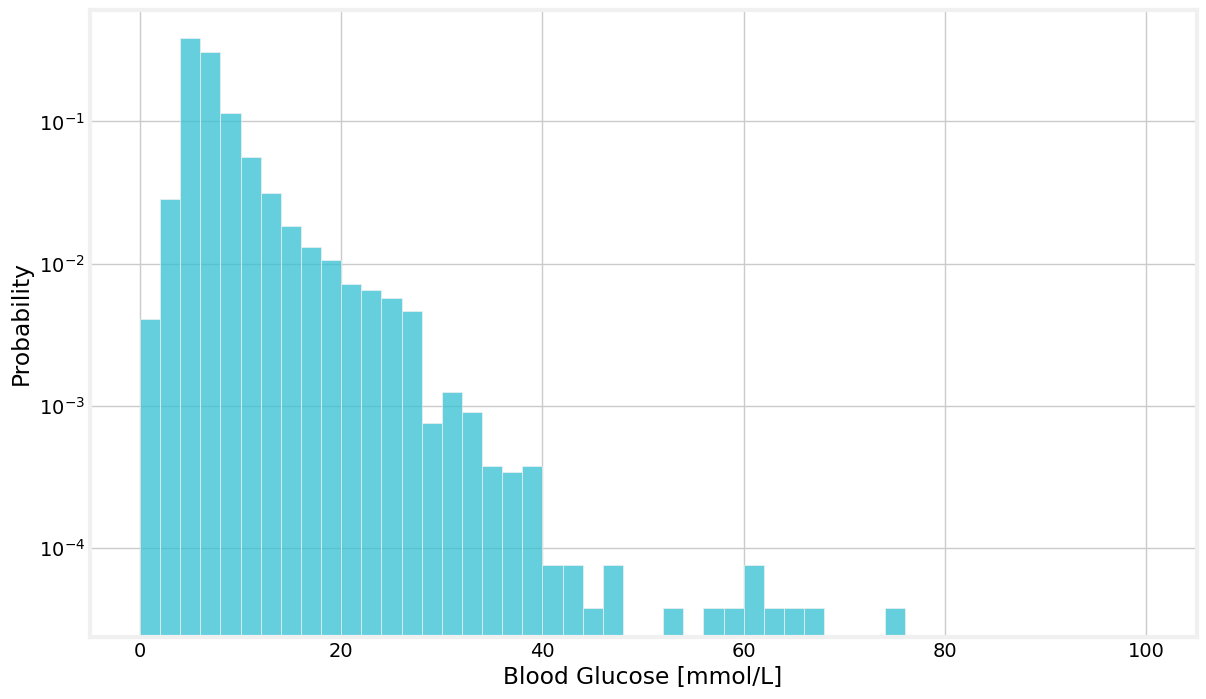

<Figure size 640x480 with 0 Axes>

In [89]:
from matplotlib.colors import to_rgba


warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)


plt.style.use('./CEIH.mplstyle')
color_dict = {0: to_rgba('#32C0D2', 1),
                1: to_rgba("#E0B165", 1),}

# key='FirstTotalHaemoglobinArterial'

# for key in plotSettings.keys():
fig, ax = plt.subplots(figsize=(12, 7))
fig.tight_layout() 
plotSettingValues = plotSettings[key]
# print(plotSettingValues)
# print(key)
sns.histplot(data=Emergency_IPInfo_Complete_Numeric.loc[~Emergency_IPInfo_Complete_Numeric[key].isna()], x=key,  stat= 'probability', bins=plotSettingValues[0], 
            label=plotSettingValues[4] ,palette=color_dict,binrange=(plotSettingValues[1], plotSettingValues[2]))
ax.set(xlabel=plotSettingValues[4])
plt.yscale(plotSettingValues[3])
plt.figure()


FirstAlbumin
Albumin Level


<Figure size 640x480 with 0 Axes>

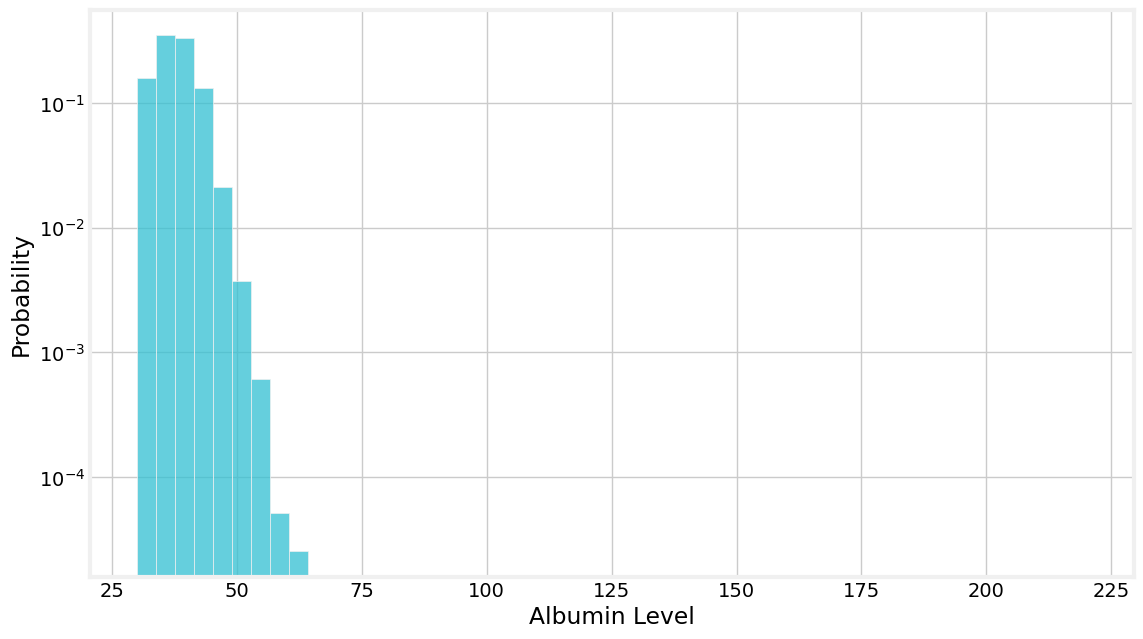

<Figure size 640x480 with 0 Axes>

In [90]:
key='FirstAlbumin'
f, ax = plt.subplots(figsize=(12, 7))
# plotSettingValues = plotSettings[key]
# print(plotSettingValues)
print(key)
print({**Obs_Of_Interest, **Res_Of_Interest}[key])
sns.histplot(data=Emergency_IPInfo_Complete_Numeric.loc[~Emergency_IPInfo_Complete_Numeric[key].isna()], x=key,  stat= 'probability', bins=50, label={**Obs_Of_Interest, **Res_Of_Interest}[key] , 
             palette=color_dict,binrange=(30,220),)
ax.set(xlabel={**Obs_Of_Interest, **Res_Of_Interest}[key])
plt.yscale('log')
# plt.yscale('linear')
plt.figure()

In [91]:
print(res2_df[res2_df.ITEMNAME=={**Obs_Of_Interest, **Res_Of_Interest}[key]].REFERENCELOWERLIMIT.unique())
print(res2_df[res2_df.ITEMNAME=={**Obs_Of_Interest, **Res_Of_Interest}[key]].REFERENCEUPPERLIMIT.unique())

['34' '31' '30' '26' '28']
['48' '40' '43']


In [92]:
key

'FirstAlbumin'

In [93]:
all_obs_df[all_obs_df.OBSERVATIONDESC=={**Obs_Of_Interest, **Res_Of_Interest}[key]]

,ObservationGUID,VISITIDCODE,CLIENTVISITGUID,CLIENTGUID,OBSITEMGUID,OBSERVATIONDESC,DATEENTERED,OBSERVATIONVALUE,SORTSEQNUM,UNITOFMEASURE


In [ ]:
for key in plotSettings.keys():
    minLimit = res2_df[res2_df.ITEMNAME=={**Obs_Of_Interest, **Res_Of_Interest}[key]].REFERENCELOWERLIMIT.unique()
    maxLimit = res2_df[res2_df.ITEMNAME=={**Obs_Of_Interest, **Res_Of_Interest}[key]].REFERENCEUPPERLIMIT.unique()
    print(key,minLimit,maxLimit)

In [ ]:
res2_df[(res2_df.ITEMNAME=={**Obs_Of_Interest, **Res_Of_Interest}[key])&(res2_df.REFERENCELOWERLIMIT=='30')]